In [1]:
#Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings 

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
pwd

'C:\\Users\\Armstrongs\\Desktop\\GitHub\\Capstone2'

In [3]:
data = 'wrangled_snapshot.csv'
df = pd.read_csv(data)
df.head()

,Unnamed: 0,DISTNAME,DISTRICT #,DZCNTYNM,REGION,DZRATING,DZCAMPUS,total students,4. Students % African American:,5. Students % Hispanic:,...,100. Expenditures % Prekindergarten:,101. Expenditures % Un-Allocated:,DISTSIZE,COMMTYPE,afrdiff,hispdiff,whidiff,asndiff,pacdiff,Racial Dif Stu/Tea
0,0,CAYUGA ISD,1902,001 ANDERSON,7,A,3,564,3.5,6.7,...,0.3,20.8,500 to 999,Rural,0,0,0,0,0,3.63125
1,1,ELKHART ISD,1903,001 ANDERSON,7,A,5,1254,5.4,11.3,...,0.0,25.7,"1,000 to 1,599",Non-metropolitan Stable,0,0,0,0,0,7.40625
2,2,FRANKSTON ISD,1904,001 ANDERSON,7,B,3,803,8.2,8.2,...,1.1,28.2,500 to 999,Rural,0,0,0,0,0,2.98750
3,3,NECHES ISD,1906,001 ANDERSON,7,A,2,366,8.5,13.9,...,0.5,35.1,Under 500,Rural,0,0,0,0,0,10.83750
4,4,PALESTINE ISD,1907,001 ANDERSON,7,B,6,3389,26.6,41.2,...,2.1,28.3,"3,000 to 4,999",Independent Town,0,0,0,0,0,23.65000


In [4]:
cleburne = df[df['DISTNAME'] == 'CLEBURNE ISD']
cleburne['COMMTYPE']

580    Other Central City Suburban
Name: COMMTYPE, dtype: object

In [5]:
BC = df[df['DISTNAME'] == 'BAY CITY ISD']
BC['COMMTYPE']

677    Independent Town
Name: COMMTYPE, dtype: object

In [6]:
df.shape

(1065, 116)

In [7]:
#Looks like all my values are non-null, everything is float type. Missing values have already been removed or imputed during
#data cleaning. Several identifying columns can be dropped from the beginning including: Unnamed: 0, DISTRICT #, DZCNTYNM,
#REGION, and DZCAMPUS. DZRATING may not be useful as it's just based on the aggregate scores of the other features.
df.iloc[:,:100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 100 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Unnamed: 0                                                     1065 non-null   int64  
 1   DISTNAME                                                       1065 non-null   object 
 2   DISTRICT #                                                     1065 non-null   int64  
 3   DZCNTYNM                                                       1065 non-null   object 
 4   REGION                                                         1065 non-null   int64  
 5   DZRATING                                                       1065 non-null   object 
 6   DZCAMPUS                                                       1065 non-null   int64  
 7   total students                                             

In [8]:
#afrdiff - pacdiff can all be dropped as they were just temporary columns created to get Racial Dif Stu/Tea. Details can be 
#Found in last notebook. DISTSIZE and COMMTYPE are going to require a closer look. 
df.iloc[:,100:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 16 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   94. Expenditures % State Compensatory Education:    1065 non-null   float64
 1   95. Expenditures % Bilingual/ESL Education:         1065 non-null   float64
 2   96. Expenditures % Career and Technical Education:  1065 non-null   float64
 3   97. Expenditures % Gifted and Talented Education:   1065 non-null   float64
 4   98. Expenditures % Athletics/Related Activities:    1065 non-null   float64
 5   99. Expenditures % High School Allotment:           1065 non-null   float64
 6   100. Expenditures % Prekindergarten:                1065 non-null   float64
 7   101. Expenditures % Un-Allocated:                   1065 non-null   float64
 8   DISTSIZE                                            1065 non-null   object 
 9

In [9]:
df['DISTSIZE'].head()

0        500 to 999
1    1,000 to 1,599
2        500 to 999
3         Under 500
4    3,000 to 4,999
Name: DISTSIZE, dtype: object

In [10]:
df['DISTSIZE'].value_counts()

Under 500           294
500 to 999          210
1,000 to 1,599      145
1,600 to 2,999      133
3,000 to 4,999       90
5,000 to 9,999       76
10,000 to 24,999     64
25,000 to 49,999     33
50,000 and over      20
Name: DISTSIZE, dtype: int64

In [11]:
df['COMMTYPE'].head()

0                      Rural
1    Non-metropolitan Stable
2                      Rural
3                      Rural
4           Independent Town
Name: COMMTYPE, dtype: object

In [12]:
df['COMMTYPE'].value_counts()

Rural                            419
Non-metropolitan Stable          166
Other Central City Suburban      164
Charters                          93
Major Suburban                    79
Independent Town                  67
Other Central City                38
Non-metropolitan Fast Growing     28
Major Urban                       11
Name: COMMTYPE, dtype: int64

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
#These two categorical variables are going to have to be one-hot encoded. Let's start with COMMTYPE
enc_commtype = OneHotEncoder(handle_unknown='ignore')
commtypecats = [['Rural', 1], ['Non-metropolitan Stable', 2], ['Other Central City Suburban', 3], ['Charters', 4], ['Major Suburban', 5], ['Independent Town', 6], ['Other Central City', 7], ['Non-metropolitan Fast Growing', 8], ['Major Urban', 9]]
enc_commtype.fit(commtypecats)

OneHotEncoder(handle_unknown='ignore')

In [15]:
enc_commtype.categories_

[array(['Charters', 'Independent Town', 'Major Suburban', 'Major Urban',
        'Non-metropolitan Fast Growing', 'Non-metropolitan Stable',
        'Other Central City', 'Other Central City Suburban', 'Rural'],
       dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object)]

(array([1.035e+03, 2.000e+01, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

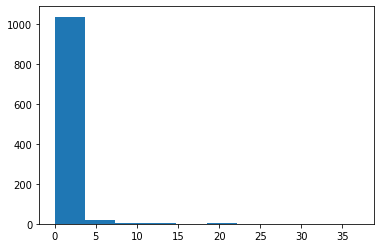

In [16]:
#I'm pretty sure I'm doing hot encoding incorrectly. I'm just going to drop the categorical data for now. I have plenty of 
#Other features. My plan for the deprendent variable is to use dropout rate. Let's take a look at it. 
plt.hist(df['18. Annual Dropout Rate Gr. 9-12 (2017-18):'])

In [17]:
#This is definitely not normally distributed. Let's checkout some statistics for dropout rates and compare them to my target
#district
df['18. Annual Dropout Rate Gr. 9-12 (2017-18):'].describe()

count    1065.000000
mean        0.889355
std         2.103651
min         0.000000
25%         0.000000
50%         0.400000
75%         1.100000
max        37.000000
Name: 18. Annual Dropout Rate Gr. 9-12 (2017-18):, dtype: float64

In [18]:
df.loc[df['DISTNAME'] == 'CLEBURNE ISD', ['18. Annual Dropout Rate Gr. 9-12 (2017-18):']]

,18. Annual Dropout Rate Gr. 9-12 (2017-18):
580,2.0


In [19]:
#Let's just seperate it for easier reference
cleburne = df[df['DISTNAME'] == 'CLEBURNE ISD']

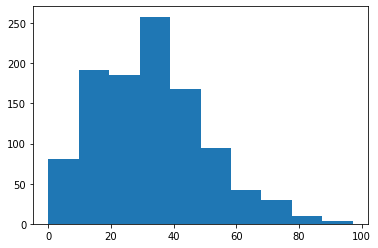

In [20]:
#It looks like the dropout rate for Cleburne ISD is well above the mean and in the top 75% of the data. There are some serious
#outliers though. There are a few other features that might make attractive dependent variables though. Let's check those
#out as well. 
plt.hist(df['39. SAT/ACT Results - % At or Above Criterion (2017-2018): '])
plt.show()

In [21]:
cleburne['39. SAT/ACT Results - % At or Above Criterion (2017-2018): ']

580    30.0
Name: 39. SAT/ACT Results - % At or Above Criterion (2017-2018): , dtype: float64

In [22]:
df['39. SAT/ACT Results - % At or Above Criterion (2017-2018): '].describe()

count    1065.000000
mean       32.457522
std        17.355193
min         0.000000
25%        19.000000
50%        32.100000
75%        42.700000
max        97.200000
Name: 39. SAT/ACT Results - % At or Above Criterion (2017-2018): , dtype: float64

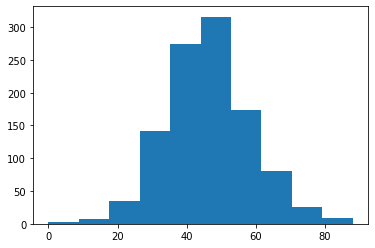

In [23]:
#Cleburne is right around average in terms of SAT performance. 
plt.hist(df['staar all subjects meet'])
plt.show()

In [24]:
cleburne['staar all subjects meet']

580    36.0
Name: staar all subjects meet, dtype: float64

In [25]:
df['staar all subjects meet'].describe()

count    1065.000000
mean       46.130516
std        12.098082
min         0.000000
25%        38.000000
50%        46.000000
75%        53.000000
max        88.000000
Name: staar all subjects meet, dtype: float64

In [26]:
#Looking at these graphs it seems to me like dropout rates are pretty uniform across most school districts and there may
#be some underlying issues that cause dropout rates to go WAY HIGHER for certain areas. Since staar performance has a 
#much greater range, is more normally distributed (though it does seem right tailed), and my target district is much lower
#than the mean for this feature I've decided to predict staat performance instead. 

#The next step is to cut the dataset down into just features that might relate to staar performance using my own domain
#knowledge

In [27]:
df = df.drop(columns=['Unnamed: 0', 'DISTRICT #', 'DZCNTYNM',
'REGION', 'DZCAMPUS', 'DZRATING', 'DISTSIZE', 'COMMTYPE', 'afrdiff', 'hispdiff', 'whidiff', 'asndiff', 'pacdiff'])

In [28]:
#Now let's split the dataframe up and put the dependent variable in each set. 
target = df['staar all subjects meet']

In [29]:
df1 = df.iloc[:,:33]
df2 = df.iloc[:, 33:66]
df3 = df.iloc[:, 66:]

In [30]:
df1['target'] = target
df2['target'] = target
df3['target'] = target
df1.drop(columns=['staar all subjects meet'], inplace = True)


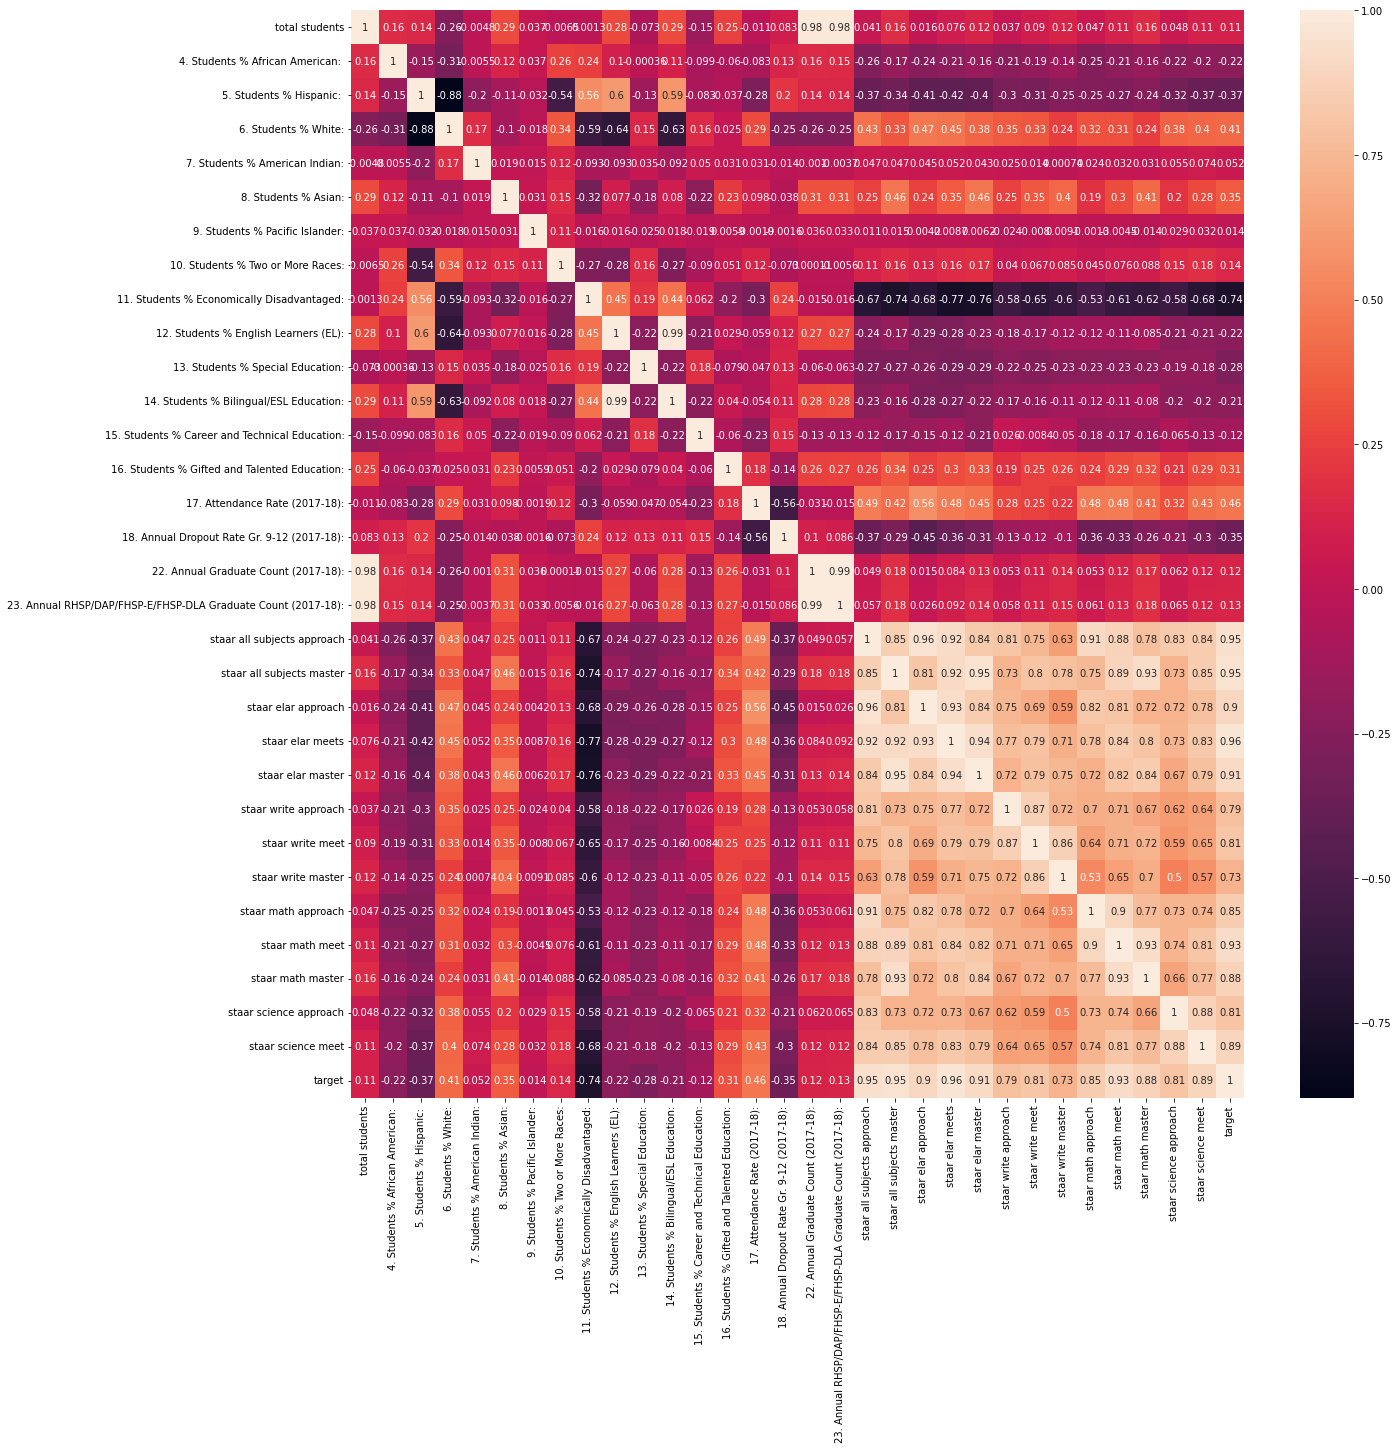

In [31]:
plt.figure(figsize = (20, 20))
sns.heatmap(df1.corr(), annot=True)
plt.show()

In [32]:
#Ok looking at this I should have already guessed that staar meets is going to correlate with star master. Let's just get rid of
#all the staar data that isn't part of the target
df1.drop(columns = ['staar all subjects approach', 'staar all subjects master',
       'staar elar approach', 'staar elar meets', 'staar elar master',
       'staar write approach', 'staar write meet', 'staar write master',
       'staar math approach', 'staar math meet', 'staar math master',
       'staar science approach', 'staar science meet'], inplace=True)

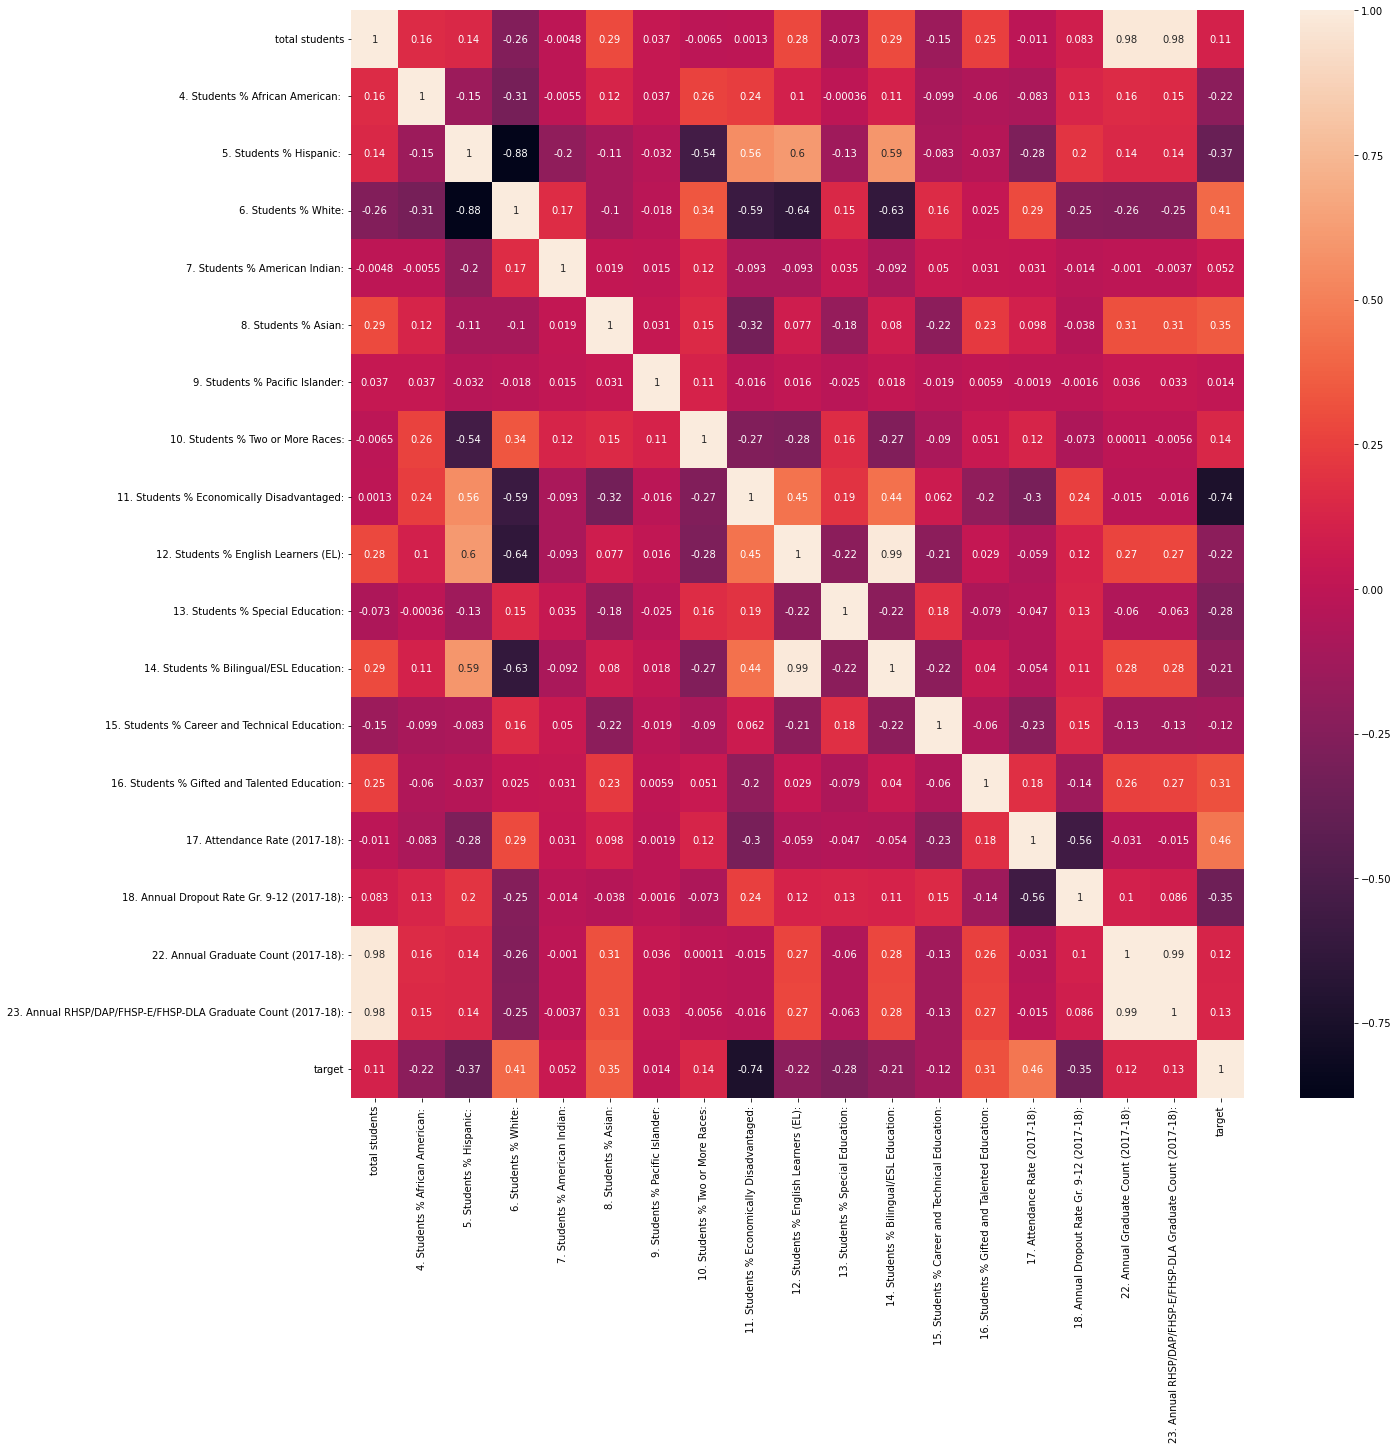

In [33]:
plt.figure(figsize = (20, 20))
sns.heatmap(df1.corr(), annot=True)
plt.show()

In [34]:
#So here our target most strongly correlates to attendence rate. I'm sure this is already common knowledge to most school
#districts. Let's see if I can find something more insightful. 

In [35]:
df2.drop(columns = ['staar science master', 'staar social approach', 'staar social meet',
       'staar social master', 'econ disad approach', 'econ disad meet',
       'econ disad master', '38. SAT/ACT Results - % Tested (2017-2018):',
       '39. SAT/ACT Results - % At or Above Criterion (2017-2018): '], inplace = True)

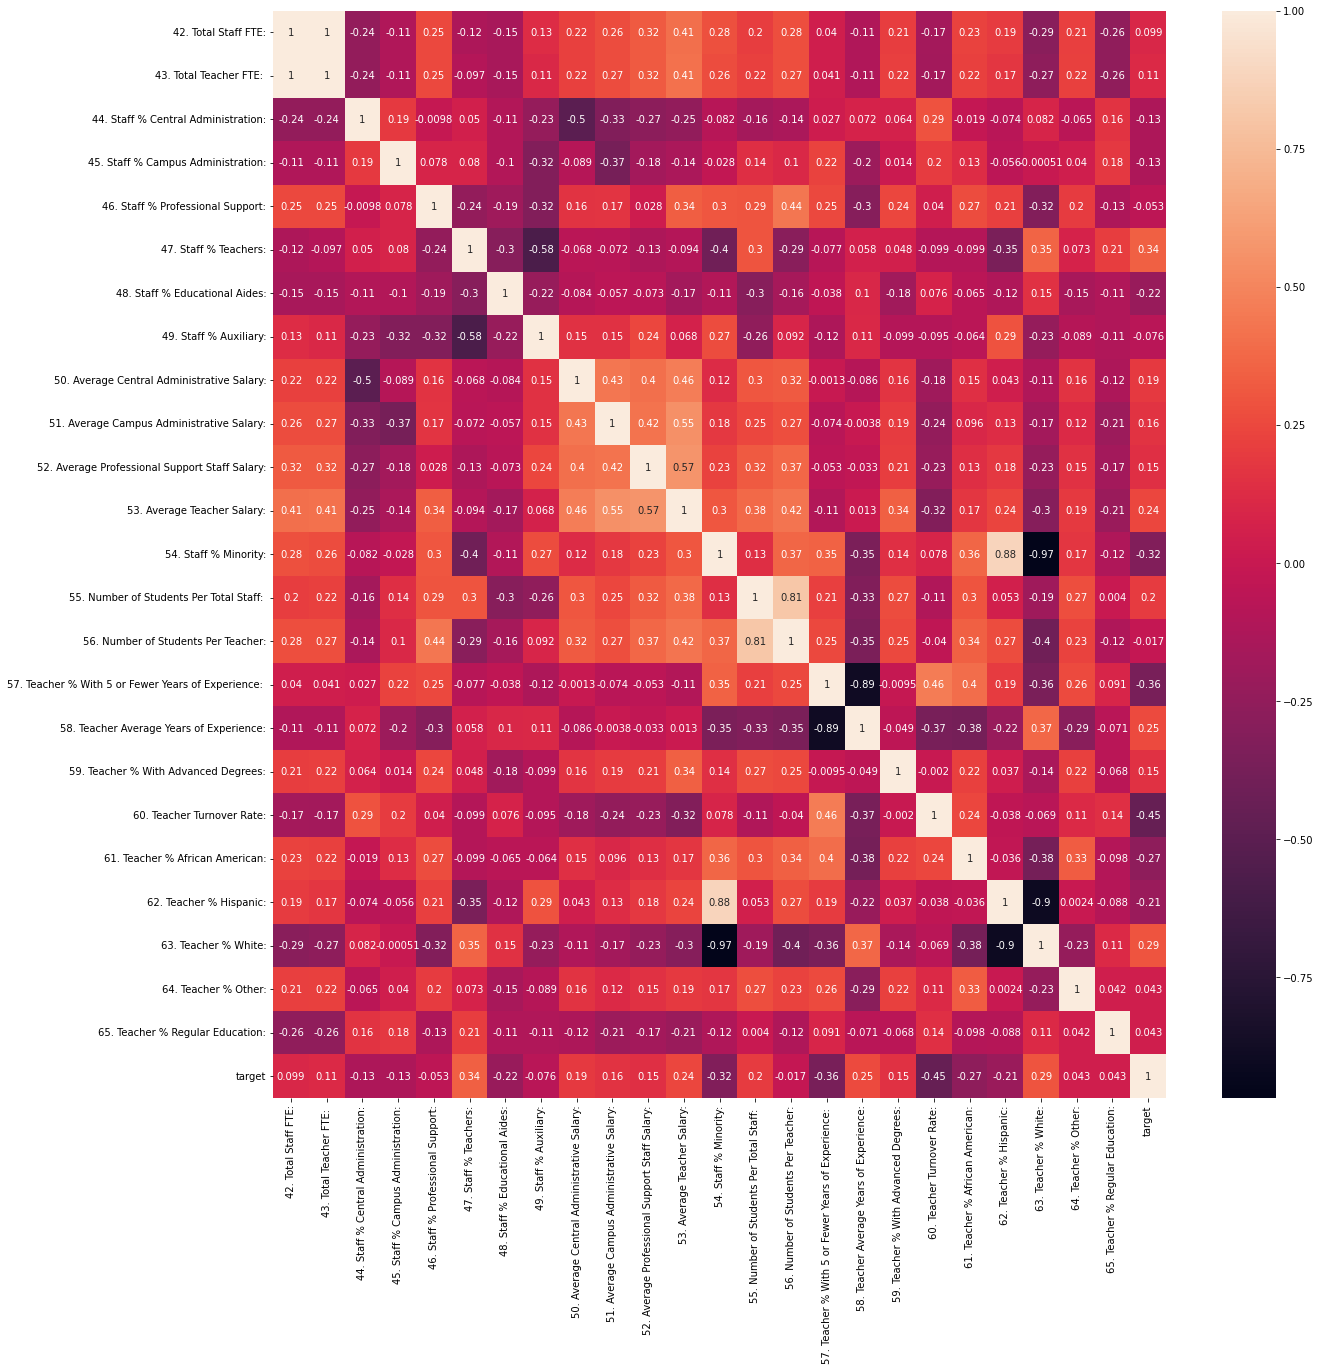

In [36]:
plt.figure(figsize = (20, 20))
sns.heatmap(df2.corr(), annot=True)
plt.show()

In [37]:
#Looks like there's a weak correlation between staff % who are teachers as well as average teacher salary and the percent
#of teachers with advanced degrees. Again all this is fairly obvious however. 
#Looks like there is a negative correlation 

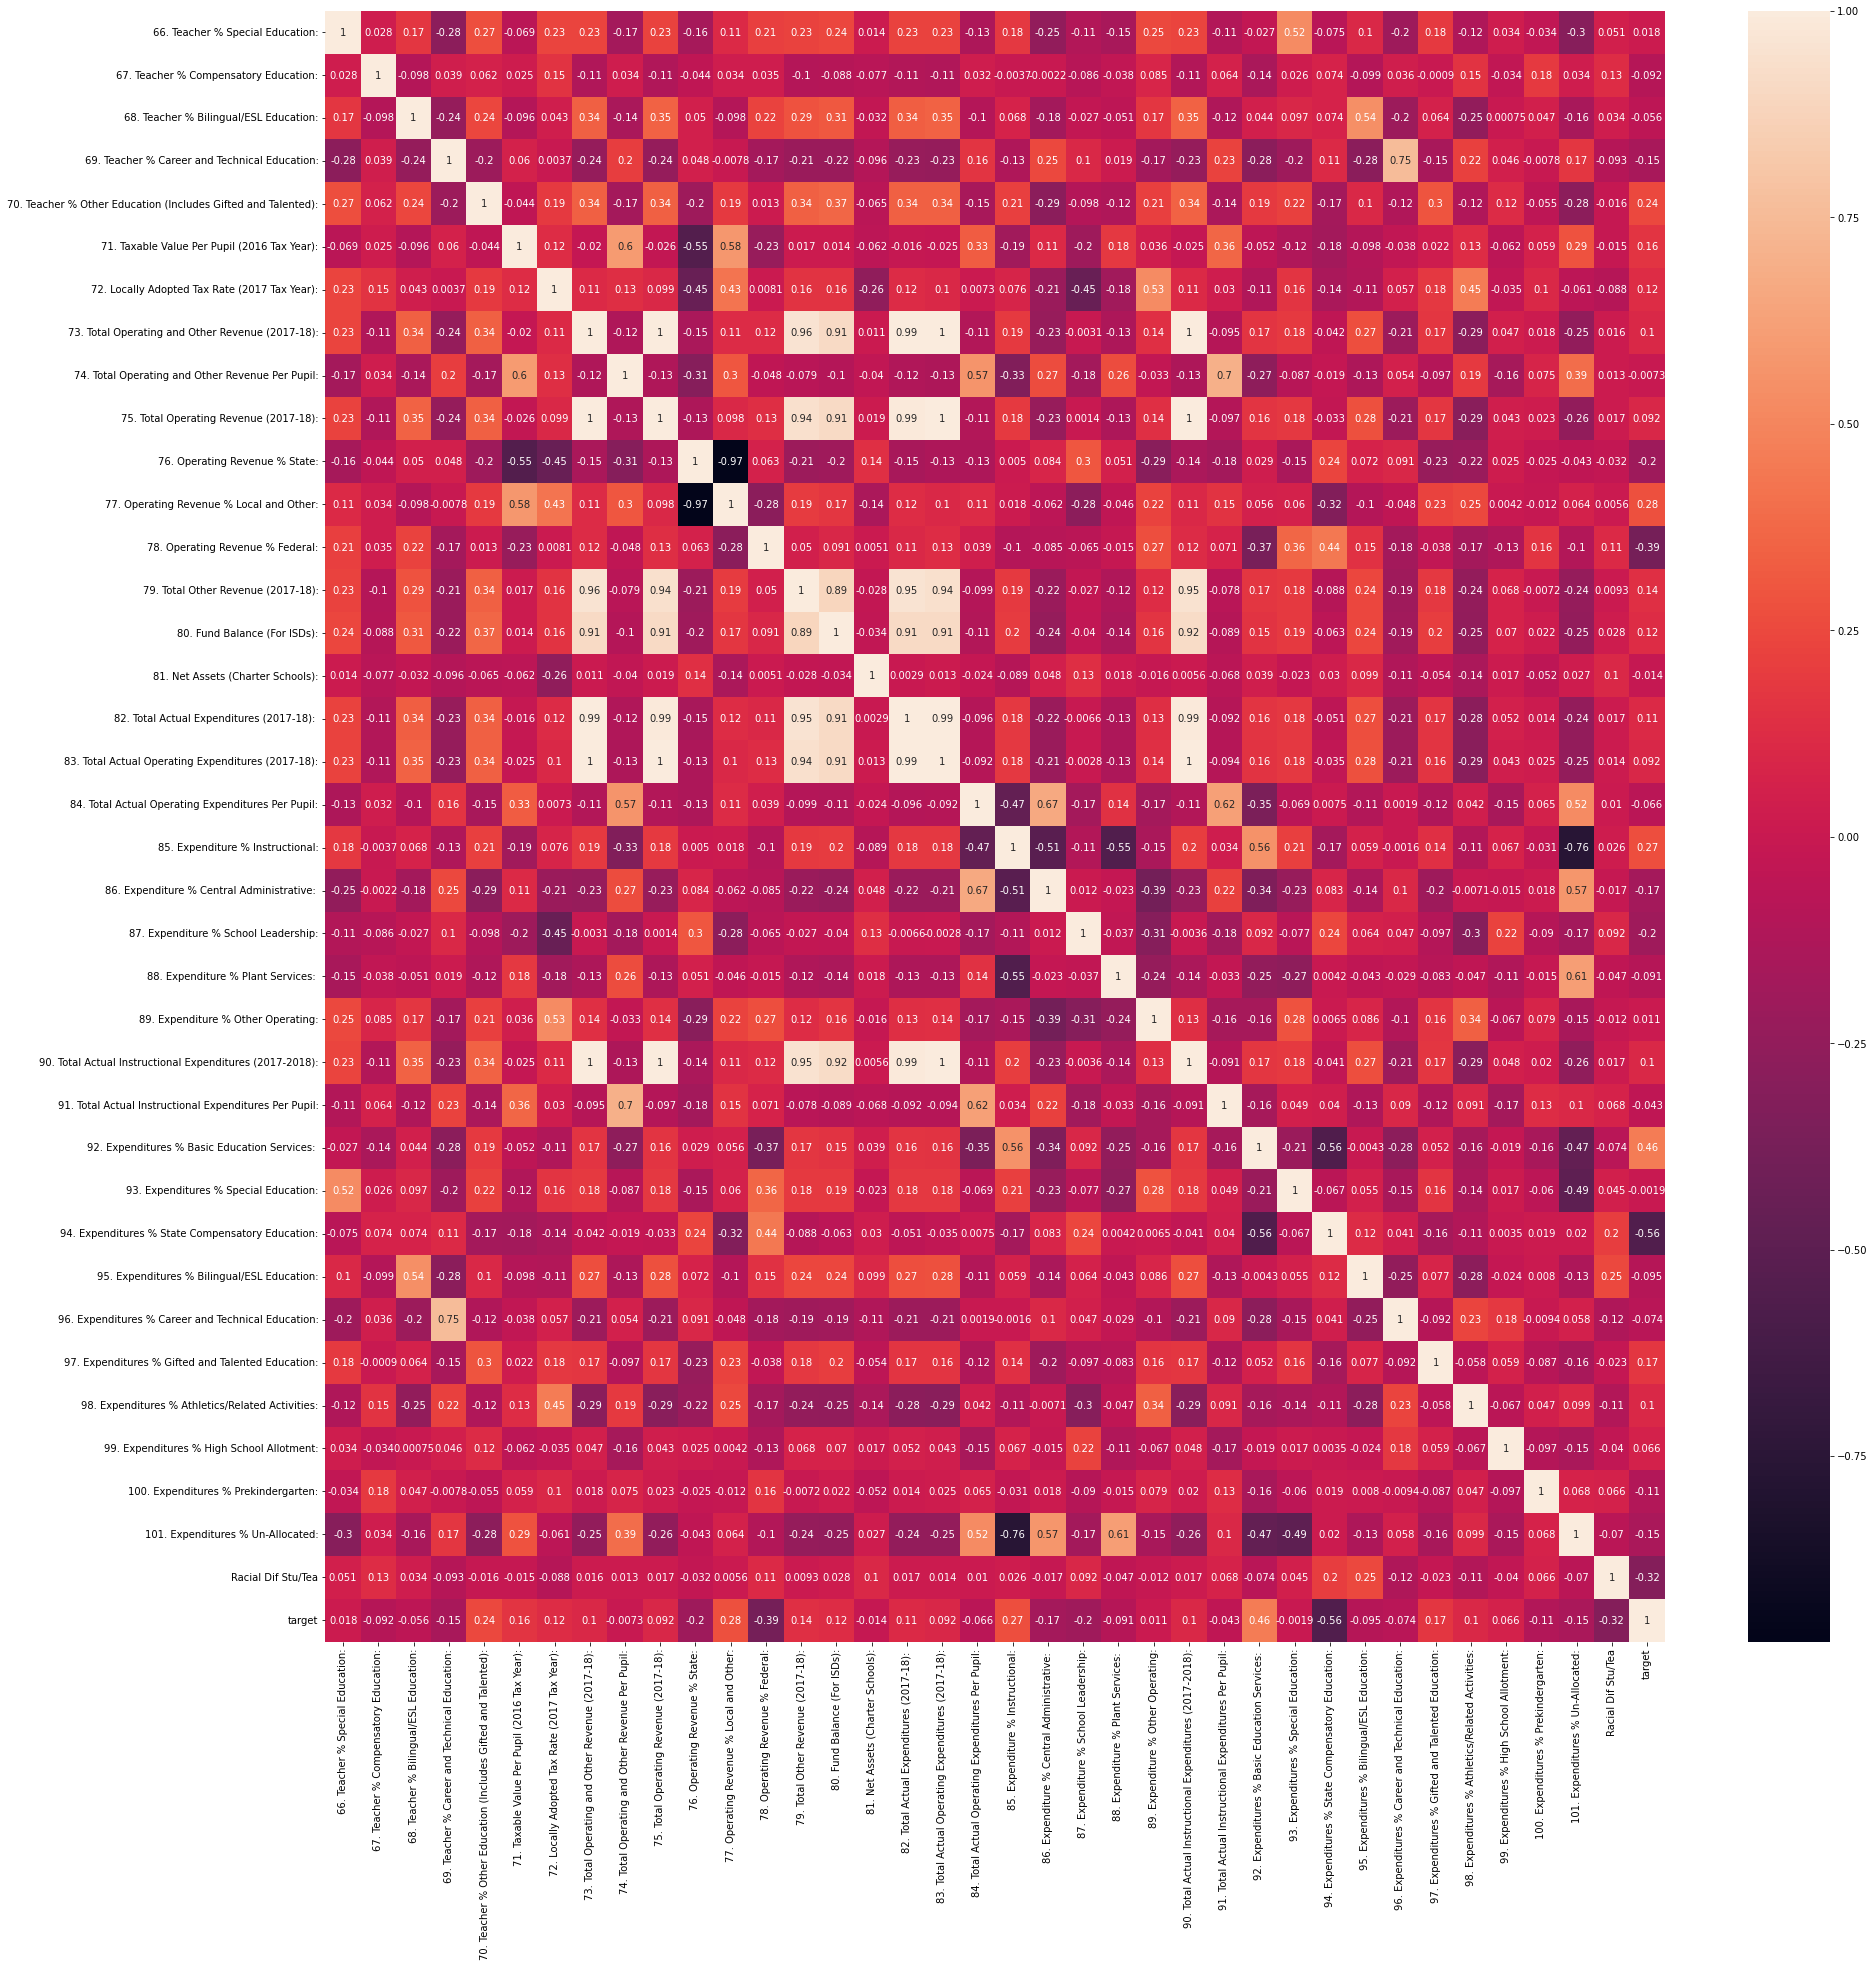

In [38]:
plt.figure(figsize = (30, 30))
sns.heatmap(df3.corr(), annot=True)
plt.show()

In [39]:
#Ah ha! There IS a negative correlation between the ratial diffrences of teachers and staff and staar scores, although it's not 
#Very strong. 
#Since there seemed to be no one (actionable) factor that had a significant correlation to staar scores I'm going to skip
#straight into a multiple linear regression model, though I'm not going to use ALL of my features. I WANT to do a principal
#component analysis but since that is getting covered in a later chapter in more detail and I was very fuzzy on how it worked
#for the ski resort capstone I'm instead going to choose the features with the highest absolute pearson scores, make sure a 
#few of those features are actionable, and create a multiple linear regression model based on what I've got. 

In [40]:
cdf1 = df1.corr()

In [41]:
cdf1 = cdf1.loc[abs(cdf1['target']) > .3]
cdf1.reset_index(inplace=True)
cdf1.iloc[:,0]

0                         5. Students % Hispanic: 
1                             6. Students % White:
2                             8. Students % Asian:
3       11. Students % Economically Disadvantaged:
4    16. Students % Gifted and Talented Education:
5                   17. Attendance Rate (2017-18):
6      18. Annual Dropout Rate Gr. 9-12 (2017-18):
7                                           target
Name: index, dtype: object

In [42]:
features_list = list(cdf1.iloc[:,0])

In [43]:
features_list

['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):',
 'target']

In [44]:
cdf2 = df2.corr()
cdf2 = cdf2.loc[abs(cdf2['target']) > .3]
cdf2.reset_index(inplace=True)
features_list.append(list(cdf2.iloc[:,0]))
features_list

['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):',
 'target',
 ['47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:',
  'target']]

In [45]:
cdf3 = df3.corr()
cdf3 = cdf3.loc[abs(cdf3['target']) > .3]
cdf3.reset_index(inplace=True)
features_list.append(list(cdf3.iloc[:,0]))
features_list

['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):',
 'target',
 ['47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:',
  'target'],
 ['78. Operating Revenue % Federal:',
  '92. Expenditures % Basic Education Services: ',
  '94. Expenditures % State Compensatory Education:',
  'Racial Dif Stu/Tea',
  'target']]

In [46]:
features_list = ['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):','47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:','78. Operating Revenue % Federal:',
  '92. Expenditures % Basic Education Services: ',
  '94. Expenditures % State Compensatory Education:',
  'Racial Dif Stu/Tea']

In [47]:
dfcut = df[['DISTNAME','5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):','47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:','78. Operating Revenue % Federal:',
  '92. Expenditures % Basic Education Services: ',
  '94. Expenditures % State Compensatory Education:',
  'Racial Dif Stu/Tea']]
dfcut['target'] = target
dfcut.set_index('DISTNAME', inplace = True)
dfcut.head()

C:\Users\ARMSTR~1\AppData\Local\Temp/ipykernel_4156/1961524914.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcut['target'] = target


,5. Students % Hispanic:,6. Students % White:,8. Students % Asian:,11. Students % Economically Disadvantaged:,16. Students % Gifted and Talented Education:,17. Attendance Rate (2017-18):,18. Annual Dropout Rate Gr. 9-12 (2017-18):,47. Staff % Teachers:,54. Staff % Minority:,57. Teacher % With 5 or Fewer Years of Experience:,60. Teacher Turnover Rate:,78. Operating Revenue % Federal:,92. Expenditures % Basic Education Services:,94. Expenditures % State Compensatory Education:,Racial Dif Stu/Tea,target
DISTNAME,,,,,,,,,,,,,,,,
CAYUGA ISD,6.7,84.8,0.5,42.6,8.5,96.5,0.0,51.0,14.1,11.8,7.8,19.3,32.0,3.1,3.63125,61.0
ELKHART ISD,11.3,78.1,0.3,58.1,3.6,96.4,0.0,57.2,10.5,15.1,11.7,6.9,46.2,6.6,7.40625,56.0
FRANKSTON ISD,8.2,78.2,1.0,53.7,8.8,95.4,0.4,49.7,13.3,32.5,30.5,7.0,40.1,7.6,2.98750,53.0
NECHES ISD,13.9,73.2,0.0,47.8,6.0,95.9,0.9,52.4,12.5,26.9,14.4,8.4,36.7,10.2,10.83750,52.0
PALESTINE ISD,41.2,27.5,0.9,74.9,2.9,95.3,0.0,51.7,28.5,34.3,26.1,18.3,46.6,8.1,23.65000,42.0


In [48]:
#Ok the most significant features have been selected. In this case I believe my actionable features are: Attendance rate(Although
# this is a primary goal for every school district), staff % teachers (which would demonstrate that too much support staff like
# non classroom subject matter specialists, interventionalists, ect are not as effective as hiring more teachers), staff % 
# minority (which is really exciting because it may demonstrate that having diverse staff is helpful as opposed to a diverse 
#student population being harmful), teacher turnover rate (Keep your teachers, raise your scores though I know I'm implying
#causation here), and racial differences between students and staff (highering teachers who look like your students may be
#helpful.) 

#The other features are useful for predictive purposes even if they aren't actionable. 


In [49]:
dfcut.to_csv('snapshot_sig_features.csv')

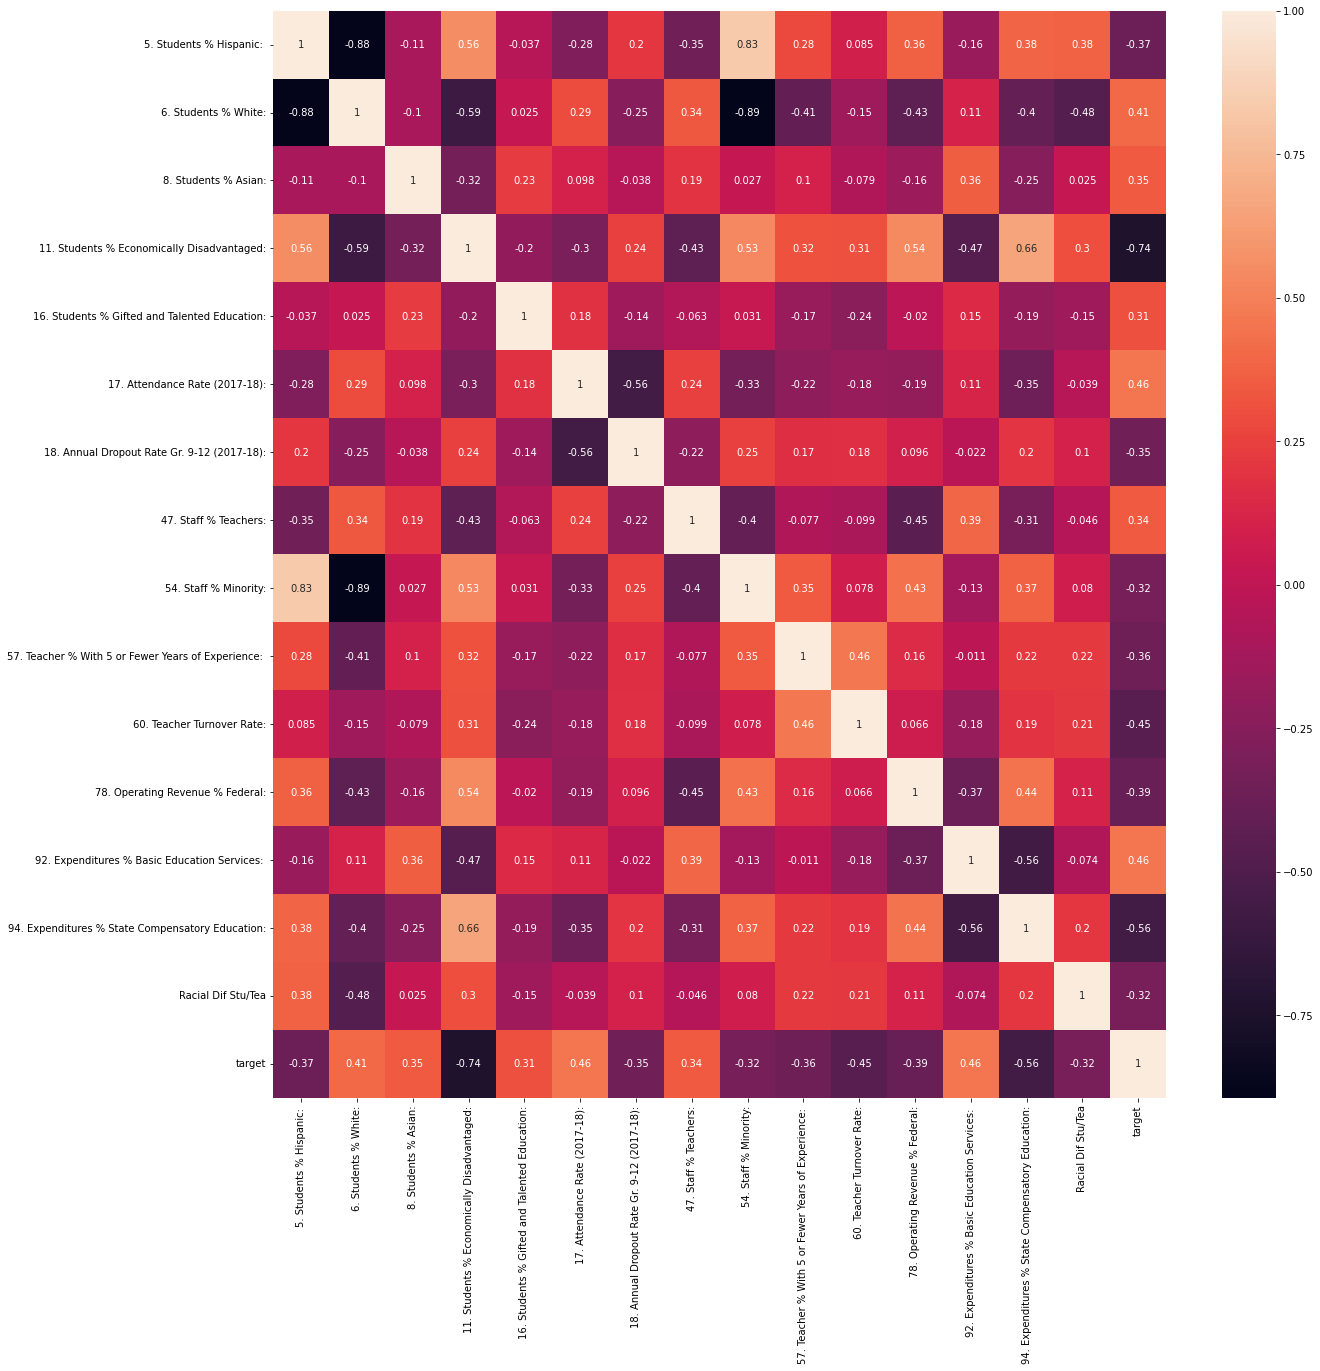

In [50]:
plt.figure(figsize = (20, 20))
sns.heatmap(dfcut.corr(), annot=True)
plt.show()

In [51]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'target', data=dfcut, alpha=0.5)
        ax.set(xlabel=col, ylabel='Staar Meets')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

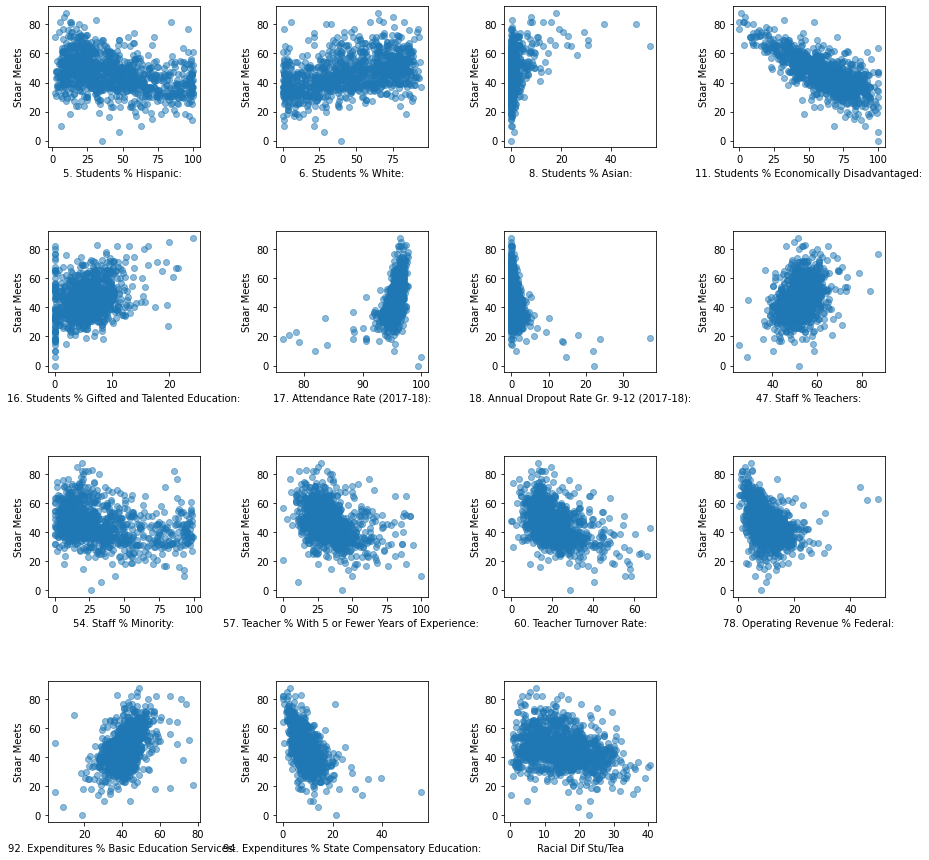

In [52]:
features = [i for i in dfcut.columns if i not in ['target']]
scatterplots(features, ncol=4, figsize=(15, 15))

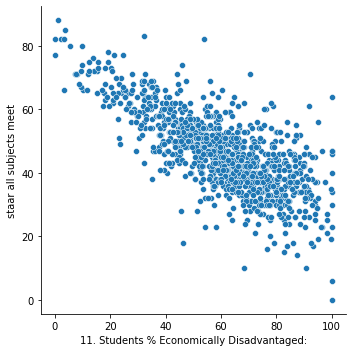

In [53]:
sns.relplot(x='11. Students % Economically Disadvantaged:', y='staar all subjects meet', data=df)

In [54]:
#I'm seeing a few interesting patterns here. Notably attendance rate doesn't seem to have much of an impact on staar performance
#Until you get to around 95%. Schools with high dropout rates don't perform well, but low dropout rates don't tend to correlate
#with any improvement. Staff % minority is actually negitively correlated which is dissapointing. Teacher turnover rate is 
#Interesting because it seems to be related to teachers with 5 or fewer years of experiance. That makes sense because the more
#teachers quit the more new hires a district will need. I wonder if that causes the lower staar performance or if it's a symptom
#of it. 

#I've got one last question before I finish up. My original suscpicion was that a diverse staff that more closely resembles the 
#student population would lead to more student engagement. However what I might have just demonstrated was that schools in 
# non-asian minority areas (which would have a large population of non-white teachers as well as students) just don't tend 
# to perform as well. This could be due to a myriad of factors including systematic problems beyond the scope of this 
# project. 

#I am going to see how closely race collelates to being economically disadvantaged. If they are related it might mean that
#diverse highering is not as important (for staar performance), as lifting communities out of poverty. 

(array([680., 246., 139.]),
 array([ 0. , 33.1, 66.2, 99.3]),
 <BarContainer object of 3 artists>)

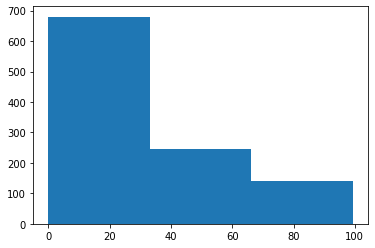

In [55]:
plt.hist(df['54. Staff % Minority:'], bins=3)

In [56]:
df['staff_race'] = pd.cut(df['54. Staff % Minority:'], bins=[0, 33.1, 66.2, float('Inf')], labels=['low_div', 'mod_div', 'high_div'])

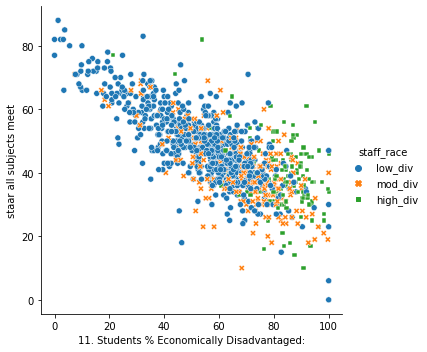

In [57]:
sns.relplot(x='11. Students % Economically Disadvantaged:', y='staar all subjects meet', style='staff_race', hue='staff_race', data=df, kind='scatter')

In [58]:
#Hmmm... Maybe I was too cynical in my original thought process. The graph here seems to suggest that being economically 
#disadvataged has a large effect on staar performance, and that low diversity schools tend to have fewer poor students. However
#it looks like for poorer school districts, having a diverse staff may correlate to higher staar scores. 

#I wonder what the trend would look like if I only looked at economically disadvanged areas or areas with large minority 
#populations

(array([144.,  82.,  90., 100., 112., 108., 112., 136., 123.,  58.]),
 array([ 0.  ,  9.46, 18.92, 28.38, 37.84, 47.3 , 56.76, 66.22, 75.68,
        85.14, 94.6 ]),
 <BarContainer object of 10 artists>)

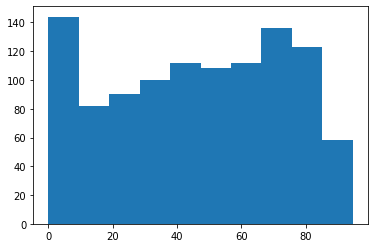

In [59]:

plt.hist(df['6. Students % White:'], bins=10)

(array([103., 542., 420.]),
 array([  0.        ,  33.33333333,  66.66666667, 100.        ]),
 <BarContainer object of 3 artists>)

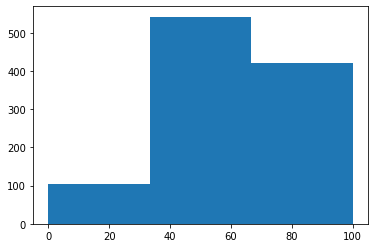

In [60]:
plt.hist(df['11. Students % Economically Disadvantaged:'], bins=3)

In [61]:
df['student_race'] = pd.cut(df['6. Students % White:'], bins=[0, 10, 66.0, float('Inf')], labels=['high_minority', 'med_minority', 'low_minority'])
df['student_econ'] = pd.cut(df['11. Students % Economically Disadvantaged:'], bins=[0, 33, 66, float('Inf')], labels=['high_wealth', 'med_wealth', 'low_wealth'])

In [62]:
onlyhighminority = df[df['student_race'] == 'high_minority']
onlyminority = df[df['student_race'] != 'low_minority']
only_low_wealth = df[df['student_econ'] == 'low_wealth']

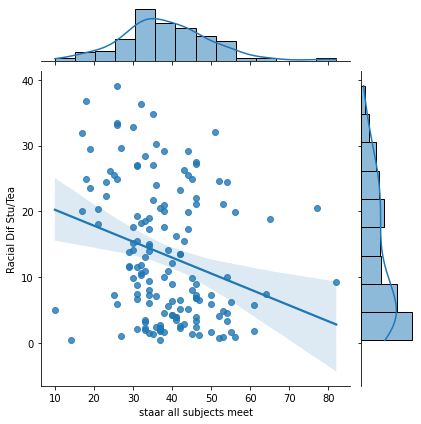

In [63]:
sns.jointplot(x = 'staar all subjects meet', y = 'Racial Dif Stu/Tea', data = onlyhighminority, kind="reg")

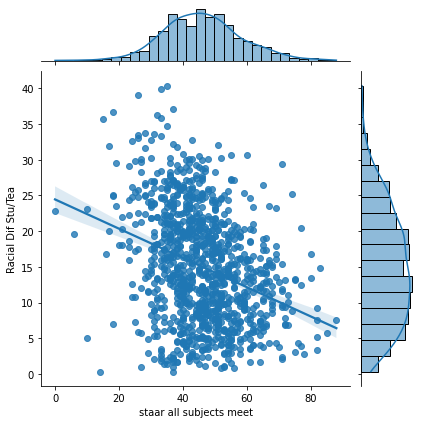

In [64]:
sns.jointplot(x = 'staar all subjects meet', y = 'Racial Dif Stu/Tea', data = df, kind="reg")

In [65]:
def pearson_r(x, y):
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)
 
    # Return entry [0,1]
    return corr_mat[0,1]

In [66]:
pearson_r(x = onlyhighminority['staar all subjects meet'], y = onlyhighminority['Racial Dif Stu/Tea'])

-0.2712142744731644

In [67]:
pearson_r(x = df['staar all subjects meet'], y = df['Racial Dif Stu/Tea'])

-0.3154319514365095

In [68]:
#Ok there isn't much correlation between minority students and staff diversity. Even weaker than the whole dataset.

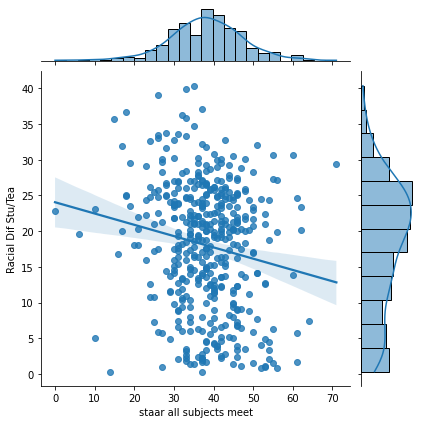

In [69]:
sns.jointplot(x = 'staar all subjects meet', y = 'Racial Dif Stu/Tea', data = only_low_wealth, kind="reg")

In [70]:
pearson_r(x = only_low_wealth['staar all subjects meet'], y = only_low_wealth['Racial Dif Stu/Tea'])
#It's the same filtered for economically disadvantaged. 

-0.16405877440282032

In [71]:
pearson_r(x = only_low_wealth['staar all subjects meet'], y = only_low_wealth['54. Staff % Minority:'])

-0.08123720382578706

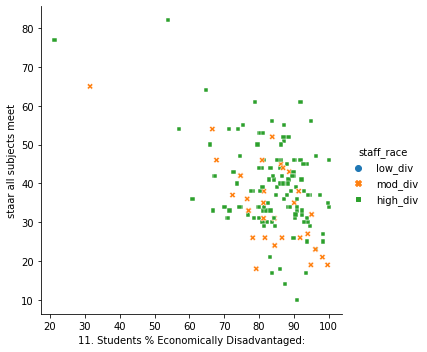

In [72]:
sns.relplot(x='11. Students % Economically Disadvantaged:', y='staar all subjects meet', style='staff_race', hue='staff_race', data=onlyhighminority, kind='scatter')

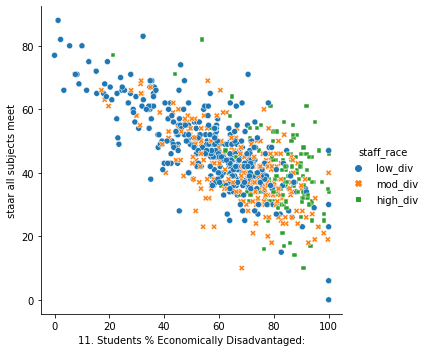

In [73]:
sns.relplot(x='11. Students % Economically Disadvantaged:', y='staar all subjects meet', style='staff_race', hue='staff_race', data=onlyminority, kind='scatter')

In [74]:
#Ok. It all makes sense now I think. I went on something of a wild goose chase. I think the rational conclusion here is that 
#areas with with high minority populations tend to be economically disadvantaged which correlates to low performance for 
# ALL racial demographics. However minority students have a wide range of staar performances that seem to be little affected 
# by the diversity of the staff. The pattern I saw with the first graph was just an illusion caused by the way the data was
#grouped. Overall racial difference still turned into one of the features with the highest pearson score, but I don't think 
#that it's actionable based on what I've seen here. Neat idea though. 

#In any case I think I've tortued the data enough. 

In [75]:
#if I took the data from the 3 buckets (diversity) and for each one used a scatterplot (pearson_r) (use this: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
#because maybe correlation is stronger when you've got different levels of diversity
#maybe can suggest that increasing divsity can reduce correlation with poverty to staar performance

In [77]:
#does teacher pay correlate to district poverty? No
#Does teacher pay correlate to teacher turnover? Somewhat
#Does turnover correlate to test scores in low income districts? More strongly
long = pd.read_csv(data)
df.head()

,DISTNAME,total students,4. Students % African American:,5. Students % Hispanic:,6. Students % White:,7. Students % American Indian:,8. Students % Asian:,9. Students % Pacific Islander:,10. Students % Two or More Races:,11. Students % Economically Disadvantaged:,...,96. Expenditures % Career and Technical Education:,97. Expenditures % Gifted and Talented Education:,98. Expenditures % Athletics/Related Activities:,99. Expenditures % High School Allotment:,100. Expenditures % Prekindergarten:,101. Expenditures % Un-Allocated:,Racial Dif Stu/Tea,staff_race,student_race,student_econ
0,CAYUGA ISD,564,3.5,6.7,84.8,0.0,0.5,0.0,4.4,42.6,...,2.8,0.1,3.6,0.6,0.3,20.8,3.63125,low_div,low_minority,med_wealth
1,ELKHART ISD,1254,5.4,11.3,78.1,0.6,0.3,0.2,4.1,58.1,...,7.8,0.1,3.4,1.0,0.0,25.7,7.40625,low_div,low_minority,med_wealth
2,FRANKSTON ISD,803,8.2,8.2,78.2,0.6,1.0,0.0,3.7,53.7,...,6.9,0.1,7.3,1.0,1.1,28.2,2.98750,low_div,low_minority,med_wealth
3,NECHES ISD,366,8.5,13.9,73.2,0.3,0.0,0.0,4.1,47.8,...,4.0,0.3,0.0,1.2,0.5,35.1,10.83750,low_div,low_minority,med_wealth
4,PALESTINE ISD,3389,26.6,41.2,27.5,0.1,0.9,0.1,3.6,74.9,...,3.9,0.2,3.4,0.7,2.1,28.3,23.65000,low_div,med_minority,low_wealth


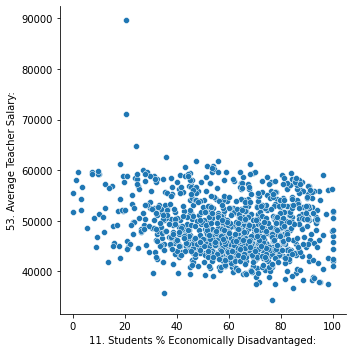

In [82]:
sns.relplot(x='11. Students % Economically Disadvantaged:', y= '53. Average Teacher Salary:', data=long)

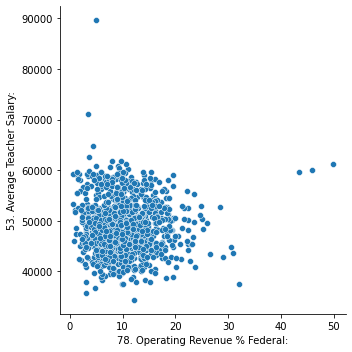

In [120]:
sns.relplot(x='78. Operating Revenue % Federal:' , y= '53. Average Teacher Salary:', data=long)

In [119]:
long[['11. Students % Economically Disadvantaged:', '53. Average Teacher Salary:']].corr()

,11. Students % Economically Disadvantaged:,53. Average Teacher Salary:
11. Students % Economically Disadvantaged:,1.000000,-0.170106
53. Average Teacher Salary:,-0.170106,1.000000


In [121]:
long[['78. Operating Revenue % Federal:', '53. Average Teacher Salary:']].corr()

,78. Operating Revenue % Federal:,53. Average Teacher Salary:
78. Operating Revenue % Federal:,1.000000,0.013365
53. Average Teacher Salary:,0.013365,1.000000


(array([ 15.,  22.,  43.,  79., 129., 205., 216., 177., 116.,  63.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

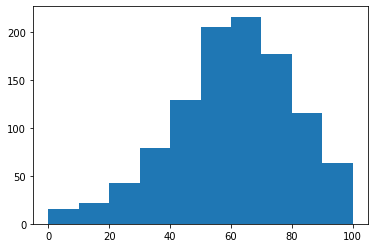

In [85]:
plt.hist(long['11. Students % Economically Disadvantaged:'])

(array([ 28., 316., 404., 215.,  98.,   2.,   1.,   0.,   0.,   1.]),
 array([34386. , 39908.2, 45430.4, 50952.6, 56474.8, 61997. , 67519.2,
        73041.4, 78563.6, 84085.8, 89608. ]),
 <BarContainer object of 10 artists>)

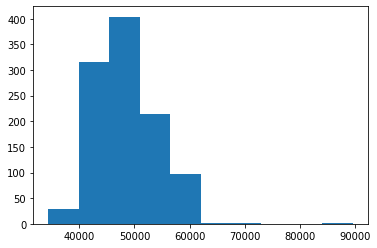

In [86]:
plt.hist(long['53. Average Teacher Salary:'])

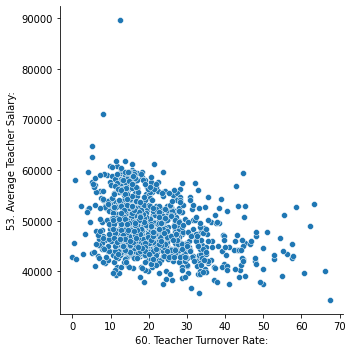

In [89]:
sns.relplot(x='60. Teacher Turnover Rate:' , y='53. Average Teacher Salary:', data=long)

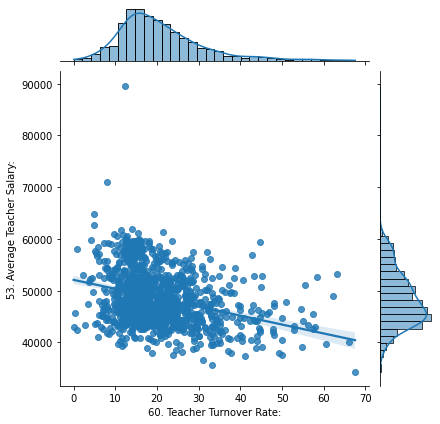

In [106]:
sns.jointplot(x = '60. Teacher Turnover Rate:', y = '53. Average Teacher Salary:', data = long, kind="reg")

In [90]:
long[['60. Teacher Turnover Rate:', '53. Average Teacher Salary:']].corr()

,60. Teacher Turnover Rate:,53. Average Teacher Salary:
60. Teacher Turnover Rate:,1.000000,-0.321943
53. Average Teacher Salary:,-0.321943,1.000000


In [95]:
long[long['53. Average Teacher Salary:']<70000][['60. Teacher Turnover Rate:', '53. Average Teacher Salary:']].corr()

,60. Teacher Turnover Rate:,53. Average Teacher Salary:
60. Teacher Turnover Rate:,1.000000,-0.322997
53. Average Teacher Salary:,-0.322997,1.000000


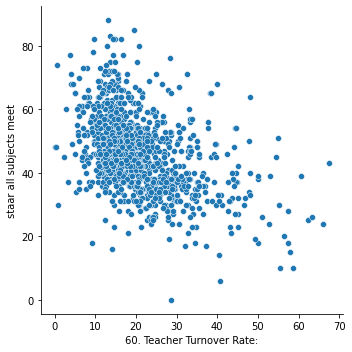

In [105]:
sns.relplot(x='60. Teacher Turnover Rate:' , y='staar all subjects meet', data=long)

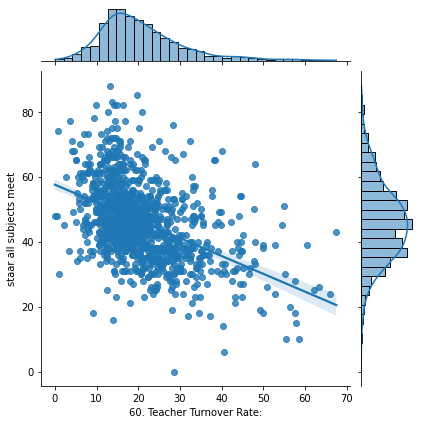

In [107]:
sns.jointplot(x = '60. Teacher Turnover Rate:', y = 'staar all subjects meet', data = long, kind="reg")

In [108]:
long[['60. Teacher Turnover Rate:', 'staar all subjects meet']].corr()

,60. Teacher Turnover Rate:,staar all subjects meet
60. Teacher Turnover Rate:,1.000000,-0.452363
staar all subjects meet,-0.452363,1.000000


In [110]:
#How does turnover affect districts that look like Cleburne? 
cleburne[['12. Students % English Learners (EL):', '14. Students % Bilingual/ESL Education:', '11. Students % Economically Disadvantaged:']]

,12. Students % English Learners (EL):,14. Students % Bilingual/ESL Education:,11. Students % Economically Disadvantaged:
580,20.0,20.7,65.2


(array([578., 224., 130.,  48.,  45.,  15.,   9.,   8.,   4.,   4.]),
 array([ 0.  ,  7.39, 14.78, 22.17, 29.56, 36.95, 44.34, 51.73, 59.12,
        66.51, 73.9 ]),
 <BarContainer object of 10 artists>)

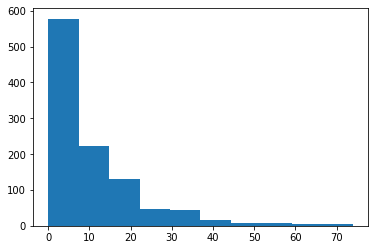

In [112]:
plt.hist(long['14. Students % Bilingual/ESL Education:'], bins=10)

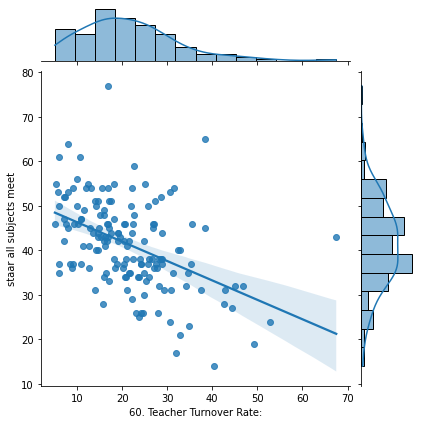

In [114]:
sns.jointplot(x = '60. Teacher Turnover Rate:', y = 'staar all subjects meet', data = long[long['14. Students % Bilingual/ESL Education:']>20], kind="reg")

In [115]:
long[long['14. Students % Bilingual/ESL Education:']>20][['60. Teacher Turnover Rate:', 'staar all subjects meet']].corr()

,60. Teacher Turnover Rate:,staar all subjects meet
60. Teacher Turnover Rate:,1.000000,-0.461185
staar all subjects meet,-0.461185,1.000000


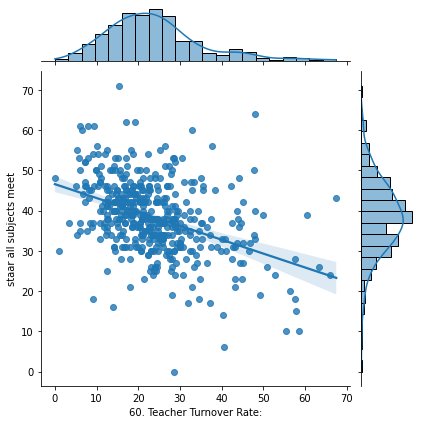

In [116]:
sns.jointplot(x = '60. Teacher Turnover Rate:', y = 'staar all subjects meet', data = long[long['11. Students % Economically Disadvantaged:']>65], kind="reg")

In [117]:
long[long['11. Students % Economically Disadvantaged:']>65][['60. Teacher Turnover Rate:', 'staar all subjects meet']].corr()

,60. Teacher Turnover Rate:,staar all subjects meet
60. Teacher Turnover Rate:,1.000000,-0.416766
staar all subjects meet,-0.416766,1.000000


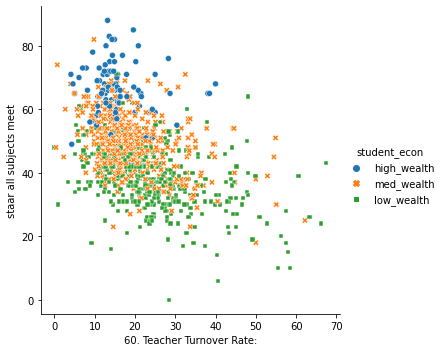

In [123]:
sns.relplot(x='60. Teacher Turnover Rate:', y='staar all subjects meet', style='student_econ', hue='student_econ', data=df, kind='scatter')

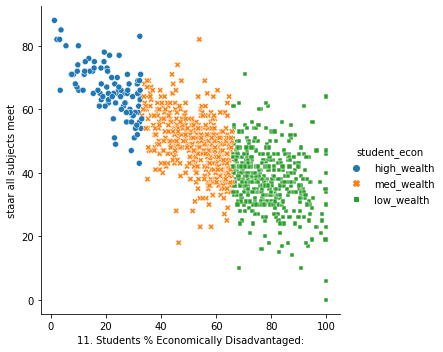

In [124]:
sns.relplot(x='11. Students % Economically Disadvantaged:', y='staar all subjects meet', style='student_econ', hue='student_econ', data=df, kind='scatter')

In [133]:
df['teacher_pay'] = pd.qcut(df['53. Average Teacher Salary:'], q=4, labels=['Low', 'Mod-Low', 'Mod-High', 'High'])

(array([ 28., 316., 404., 215.,  98.,   2.,   1.,   0.,   0.,   1.]),
 array([34386. , 39908.2, 45430.4, 50952.6, 56474.8, 61997. , 67519.2,
        73041.4, 78563.6, 84085.8, 89608. ]),
 <BarContainer object of 10 artists>)

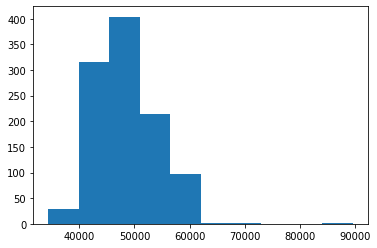

In [128]:
plt.hist(df['53. Average Teacher Salary:'])

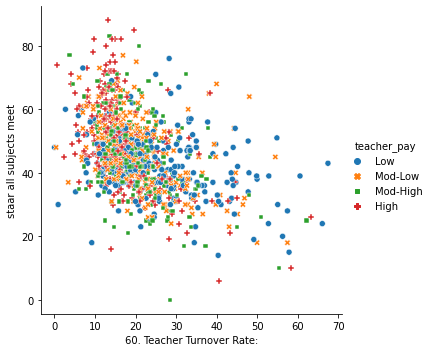

In [134]:
sns.relplot(x='60. Teacher Turnover Rate:', y='staar all subjects meet', style='teacher_pay', hue='teacher_pay', data=df, kind='scatter')